In [1]:
import pandas as pd
from abc import ABC, abstractmethod
import statsmodels.api as sm
from collections import namedtuple
from typing import Optional, List
import os

In [2]:
os.chdir(r"C:\Users\yixia\PycharmProjects\ERPB-Research")

In [3]:
def get_data():

    return pd.read_csv('erp-macro-factors-time-series.csv')


class Bucket(ABC):

    dependent_variable = 'Excess CAPE Yield'
    group_col_name = 'group'

    @abstractmethod
    def _divide(self, df, feature) -> pd.DataFrame:
        return pd.DataFrame()

    def divide(self, df, feature) -> pd.DataFrame:

        df = df[df[feature].notnull() & df[self.dependent_variable].notnull()]
        df_divided = self._divide(df.copy(), feature)

        def _norm_group_name(x):
            if pd.isnull(x):
                return x

            x = str(x)

            if len(x) == 0:
                return x

            return f" {x}"

        df_divided[self.group_col_name] = df_divided[self.group_col_name].apply(_norm_group_name)

        return df_divided[
            ['MonthYear', 'Date', self.dependent_variable, feature, self.group_col_name]
        ].set_index('MonthYear')


class QuantileBucket(Bucket):

    def __init__(self, q: int):
        self.q = q

    def _divide(self, df, feature) -> pd.DataFrame:

        df[self.group_col_name] = pd.qcut(df[feature], self.q)
        return df


class BooleanBucket(Bucket):

    def _divide(self, df, feature) -> pd.DataFrame:

        df[self.group_col_name] = df[feature]

        return df


class LabelBucket(Bucket):

    def _divide(self, df, feature) -> pd.DataFrame:

        df[self.group_col_name] = df[feature]

        return df


BucketRange = namedtuple('BucketRange', ('low', 'high'))


class CustomizedRangeBucket(Bucket):

    def __init__(self, ranges: List[BucketRange], range_names: Optional[List[str]] = None):
        self.ranges = ranges
        if range_names is None:
            range_names = [f'{r.low} to {r.high}' for r in self.ranges]
        self.range_names = range_names

    def _get_range(self, x):

        for r, name in zip(self.ranges, self.range_names):
            if r.low < x <= r.high:
                return name

        return None

    def _divide(self, df, feature) -> pd.DataFrame:

        df[self.group_col_name] = df[feature].apply(self._get_range)
        df = df[df[self.group_col_name].notnull()]

        return df

In [4]:
df = get_data()

In [10]:
def analysis(df, bucket, feature, box_plot_w_all_samples=True, figsize=(10, 5)):
    df_grouped = bucket.divide(df, feature)

    try:
        df_grouped_scatter = df_grouped.copy()
        df_grouped_scatter[feature] = df_grouped_scatter[feature].apply(float)
        df_grouped_scatter.plot.scatter(x=feature, y='Excess CAPE Yield', figsize=figsize)
    except:
        print('Scatter failed probably due to non numerical feature value')

    try:
        mod = sm.OLS(df_grouped['Excess CAPE Yield'], sm.add_constant(df_grouped[feature]))
        res = mod.fit()
        print(res.summary())
    except:
        print('Linear model failed probably due to non numerical feature value')

    # buckets
    print()
    print('Bucket Basic Stats:')
    print(df_grouped.groupby('group')['Excess CAPE Yield'].describe())
    if box_plot_w_all_samples:
        df_grouped_all = df_grouped[['Excess CAPE Yield']].copy()
        df_grouped_all['group'] = "All Samples"
        df_box = pd.concat([df_grouped_all, df_grouped[['Excess CAPE Yield', 'group']]])
    else:
        df_box = df_grouped[['Excess CAPE Yield', 'group']]

    df_box.boxplot(by="group", figsize=figsize)

In [11]:
# example 1
bucket1 = QuantileBucket(4)
feature1 = 'Fed Fund Effective Rate'

                            OLS Regression Results                            
Dep. Variable:      Excess CAPE Yield   R-squared:                       0.082
Model:                            OLS   Adj. R-squared:                  0.081
Method:                 Least Squares   F-statistic:                     73.55
Date:                Sun, 09 Apr 2023   Prob (F-statistic):           4.84e-17
Time:                        16:40:01   Log-Likelihood:                 1918.1
No. Observations:                 824   AIC:                            -3832.
Df Residuals:                     822   BIC:                            -3823.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

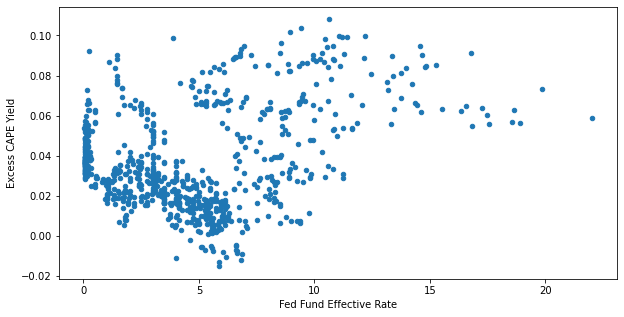

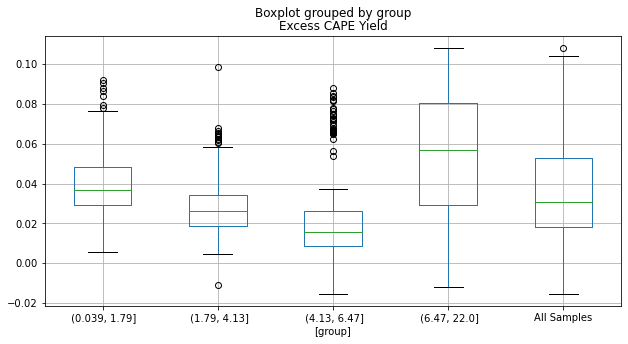

In [12]:
analysis(df, bucket1, feature1)

In [13]:
# example 2
bucket2 = BooleanBucket()
feature2 = 'In Recession'

Linear model failed probably due to non numerical feature value

Bucket Basic Stats:
         count      mean       std     min     25%     50%     75%     max
group                                                                     
 False  1269.0  0.044409  0.040222 -0.0258  0.0167  0.0327  0.0652  0.2172
 True    437.0  0.052957  0.053306 -0.0119  0.0099  0.0424  0.0733  0.2353


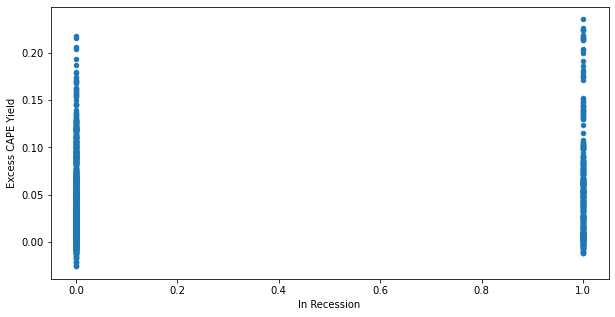

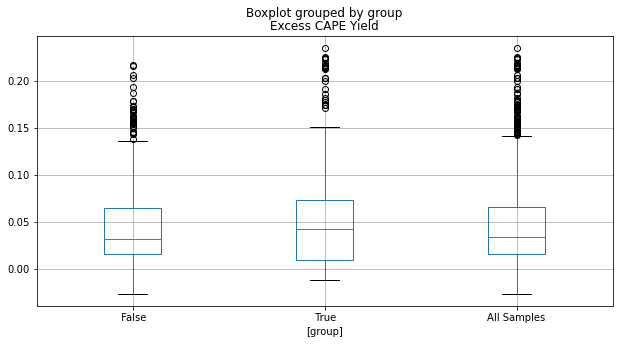

In [14]:
analysis(df, bucket2, feature2)

In [15]:
# example 3
bucket3 = CustomizedRangeBucket(
    ranges=[BucketRange(low=0, high=5), BucketRange(low=5, high=10), BucketRange(low=10, high=15)]
)
feature3 = 'Unemployment Rate'

                            OLS Regression Results                            
Dep. Variable:      Excess CAPE Yield   R-squared:                       0.037
Model:                            OLS   Adj. R-squared:                  0.036
Method:                 Least Squares   F-statistic:                     34.86
Date:                Sun, 09 Apr 2023   Prob (F-statistic):           5.03e-09
Time:                        16:40:12   Log-Likelihood:                 1829.1
No. Observations:                 902   AIC:                            -3654.
Df Residuals:                     900   BIC:                            -3645.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0221      0.00

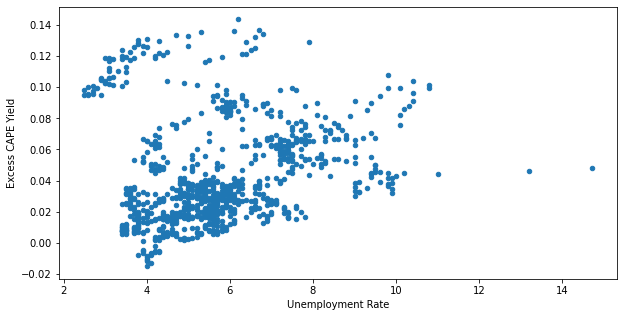

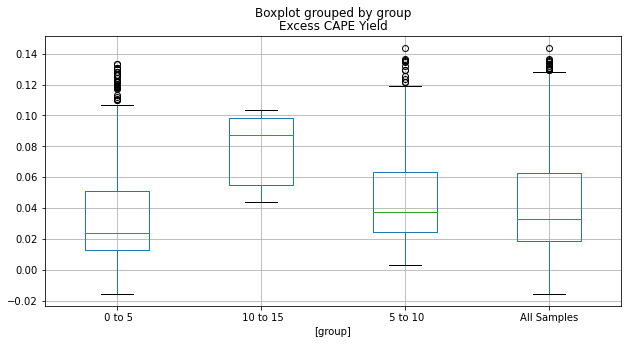

In [16]:
analysis(df, bucket3, feature3)

In [17]:
# example 4
bucket4 = QuantileBucket(4)
feature4 = 'US IG Spread Ex ERPB And Term Premia'

                            OLS Regression Results                            
Dep. Variable:      Excess CAPE Yield   R-squared:                      -0.000
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                -4.902e-14
Date:                Sun, 09 Apr 2023   Prob (F-statistic):               1.00
Time:                        16:40:30   Log-Likelihood:                 838.08
No. Observations:                 314   AIC:                            -1672.
Df Residuals:                     312   BIC:                            -1665.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


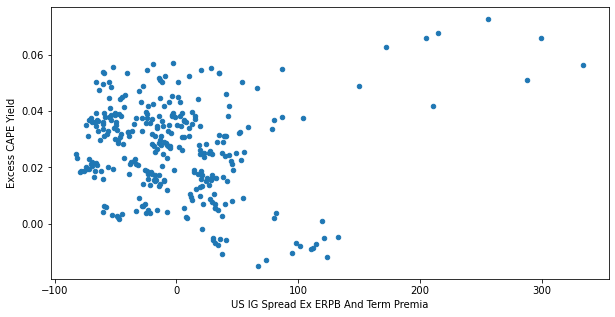

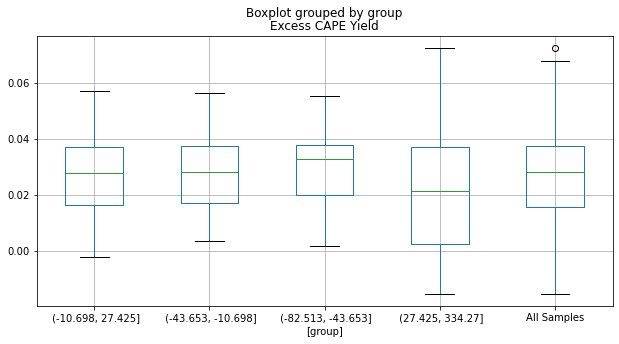

In [18]:
analysis(df, bucket4, feature4)

In [19]:
# example 5
bucket5 = LabelBucket()
feature5 = 'Recession Phase'

Scatter failed probably due to non numerical feature value
Linear model failed probably due to non numerical feature value

Bucket Basic Stats:
               count      mean       std     min       25%      50%       75%  \
group                                                                           
 1Yr After     287.0  0.049423  0.044343 -0.0110  0.019300  0.03690  0.070750   
 1Yr Before    346.0  0.046731  0.050384 -0.0258  0.005325  0.03070  0.088150   
 In Recession  437.0  0.052957  0.053306 -0.0119  0.009900  0.04240  0.073300   
 Other time    636.0  0.040884  0.030643 -0.0152  0.018300  0.03175  0.059225   

                  max  
group                  
 1Yr After     0.2172  
 1Yr Before    0.1788  
 In Recession  0.2353  
 Other time    0.1219  


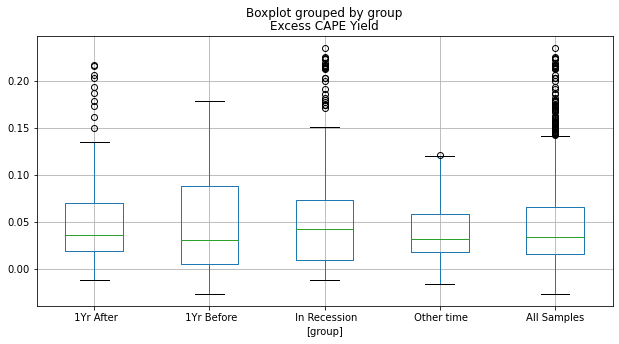

In [20]:
analysis(df, bucket5, feature5)